# Running k=7

Since the merge between the datasets created a lot of columns (over 2,000), it's necesary to reduce the dimensions of the dataset with PCA before running the k-means algorithm.

## Import Statements

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances_argmin_min, silhouette_samples

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import folium

from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import ipywidgets as widgets
from ipywidgets import interact, interactive

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [3]:
X_ = np.load("scaled-df.npy")
df = pd.read_csv("bofedales-clean.csv")

The K-Means algorithm will run on the dataset in PC space.

## Find the Optional Amount of Groups for K-Means

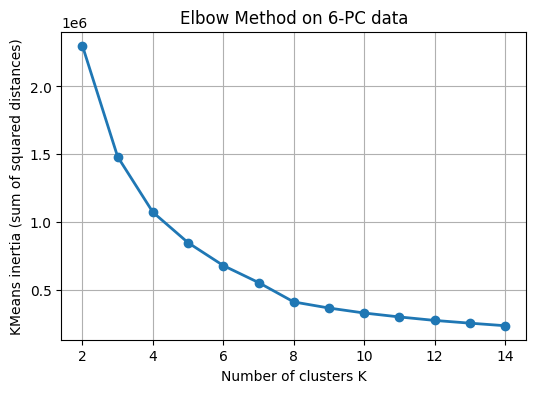

In [4]:
inertias = []
K_candidates = list(range(2, 15))

for k in K_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_candidates, inertias, marker='o', lw=2)
plt.xlabel("Number of clusters K")
plt.ylabel("KMeans inertia (sum of squared distances)")
plt.title("Elbow Method on 6-PC data")
plt.grid(True)
plt.show()

From the graph, it looks like around 5-7 is the optional k value. However, k=2 is also an optimal value.

In [5]:
def kmeans_metrics(X, k_min=2, k_max=15, random_state=42):
    rows = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X)

        rows.append(
            {
                "k": k,
                "silhouette": silhouette_score(X, labels),
                "davies_bouldin": davies_bouldin_score(X, labels),
                "calinski_harabasz": calinski_harabasz_score(X, labels),
            }
        )

    return pd.DataFrame(rows)


results = kmeans_metrics(X_, k_min=2, k_max=14)
print(results)

# Highlight the “best” K by each metric
best_k_sil = results.loc[results["silhouette"].idxmax(), "k"]
best_k_db  = results.loc[results["davies_bouldin"].idxmin(), "k"]
best_k_ch  = results.loc[results["calinski_harabasz"].idxmax(), "k"]

print(
    f"\nBest-by-metric suggestions:\n"
    f"  • Silhouette         ➜ K = {best_k_sil}\n"
    f"  • Davies-Bouldin (↓) ➜ K = {best_k_db}\n"
    f"  • Calinski-Harabasz  ➜ K = {best_k_ch}"
)

     k  silhouette  davies_bouldin  calinski_harabasz
0    2    0.704250        0.268098        2791.480831
1    3    0.490419        0.658522        3178.371016
2    4    0.451653        0.866476        3456.097292
3    5    0.462684        0.873393        3445.233408
4    6    0.487050        0.807228        3559.362944
5    7    0.480572        0.741292        3690.915275
6    8    0.544377        0.714926        4381.382113
7    9    0.488916        0.693168        4233.595603
8   10    0.495985        0.804549        4286.893976
9   11    0.498417        0.784347        4326.286214
10  12    0.488947        0.784427        4235.420426
11  13    0.465013        0.815752        3995.008086
12  14    0.466522        0.820545        4087.451788

Best-by-metric suggestions:
  • Silhouette         ➜ K = 2
  • Davies-Bouldin (↓) ➜ K = 2
  • Calinski-Harabasz  ➜ K = 8


This notebook will run k=7 in accordance with the Calinski-Harabasz metric and the elbow method. However, we will run k=2 in the following chapter. 

## Run K-Means with k=7

In [6]:
K=7
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_)
centroids_pca = kmeans.cluster_centers_ 
df["cluster"] = cluster_labels

In [7]:
cluster_means = df.groupby("cluster").mean().round(2)
cluster_means.drop("Unnamed: 0", axis=1, inplace=True)
cluster_means

Area_m2     AUC  pct_prot  elev_mean_  elev_std_m  n_wells  \
cluster                                                                 
0         58469.02  108.73      8.83     4187.01        6.91     0.00   
1        232978.72  101.47     50.32     4535.56        6.40     0.00   
2         20100.00  102.58     18.44     4115.19        5.90  3778.00   
3         21100.81  110.20     10.93     4226.67        8.19    57.13   
4         59534.07   94.73     99.88     4398.82        6.09     0.00   
5         74028.60  103.83     24.23     4266.85        7.55     0.00   
6         43987.50   96.70      0.00     4216.39        4.37     0.00   

         Ground Water Rights 1966-01-01  Ground Water Rights 1967-01-01  \
cluster                                                                   
0                                   0.0                             0.0   
1                                   0.0                             0.0   
2                                  80.0                            80.0   
3                                   0.0                             0.0   
4                                   0.0                             0.0   
5                                   0.0                             0.0   
6                                   0.0                             0.0   

         Ground Water Rights 1968-01-01  Ground Water Rights 1969-01-01  ...  \
cluster                                                                  ...   
0                                   0.0                             0.0  ...   
1                                   0.0                             0.0  ...   
2                                  80.0                            80.0  ...   
3                                   0.0                             0.0  ...   
4                                   0.0                             0.0  ...   
5                                   0.0                             0.0  ...   
6                                   0.0                             0.0  ...   

         NDWI 2019-03  NDWI 2019-04  NDWI 2019-05  NDWI 2019-06  NDWI 2019-07  \
cluster                                                                         
0                0.10          0.09          0.08          0.06          0.06   
1                0.07          0.05          0.03         -0.00         -0.02   
2                0.06          0.06          0.05          0.04          0.03   
3                0.07          0.06          0.05          0.02          0.01   
4                0.04          0.03          0.01         -0.01         -0.02   
5                0.09          0.08          0.07          0.05          0.04   
6                0.08          0.08          0.06          0.04          0.03   

         NDWI 2019-08  NDWI 2019-09  NDWI 2019-10  NDWI 2019-11  NDWI 2019-12  
cluster                                                                        
0                0.04          0.04          0.05          0.07          0.08  
1               -0.03         -0.02         -0.01          0.01          0.02  
2                0.01          0.01          0.03          0.04          0.04  
3               -0.01         -0.02         -0.00          0.01          0.02  
4               -0.03         -0.03         -0.01         -0.01          0.00  
5                0.03          0.03          0.04          0.04          0.07  
6                0.02          0.01          0.04          0.07          0.09  

[7 rows x 2289 columns]

In [8]:
print("Cluster counts:")
print(df["cluster"].value_counts().sort_index())

Cluster counts:
cluster
0    523
1    282
2    162
3    247
4    819
5    437
6     64
Name: count, dtype: int64


**List of Cluster Abbreviations**
- Cluster 0: Colchane y Pica Este (CPE)
- Cluster 1: Caquena y Parque Lauca Norte (CPLN)
- Cluster 2: Precordillera Tamarugal (PT)
- Cluster 3: Precordillera Putre (PP)
- Cluster 4: Parque Lauca Sur y Reserva Las Vicuñas (PLSRV)
- Cluster 5: General Lagos (GL)
- Cluster 6: Ollagüe y Calama (OC)

In [9]:
cluster_palette = {
    "GL":   "#693B11", # Brown
    "CPLN": "#F38D14", # Orange
    "PLSRV":"#9863D0", # Purple
    "PP":   "#C81A00", # Red
    "CPE":  "#3973ac", # Blue
    "PT":   "#339933", # Green
    "OC":   "#ff99dd", # Pink
}

df["cluster_name"] = df["cluster"].map({0: "Colchane y Pica Este", 1: "Caquena y Parque Lauca Norte", 2: "Precordillera Tamarugal", 3: "Precordillera Putre", 4: "Parque Lauca Sur y Reserva Las Vicuñas", 5: "General Lagos", 6: "Ollagüe y Calama"})
df["cluster_abr"] = df["cluster"].map({0: "CPE", 1: "CPLN", 2: "PT", 3: "PP", 4: "PLSRV", 5: "GL", 6: "OC"})
# Save the dataset
df.to_csv("bofedales-clusters7.csv")

## Numerical Analysis

Overall, the clusters seem well-seperated

In [10]:
inertia = kmeans.inertia_
avg_sq_dist_per_sample = inertia / X_.shape[0]

print(f"Average squared distance per point: {avg_sq_dist_per_sample:.4f}")

Average squared distance per point: 211.5524


In [11]:
mu = X_.mean(axis=0)
global_mse = ((X_ - mu)**2).sum(axis=1).mean()
global_mse

np.float64(2159.831865394071)

Good reduction in MSE

### Silhouette Score
A measure of well each point sits in its own cluster vs the next best one
- s≈1 ⇒ the point is well matched to its own cluster and far from the next best cluster.
- s≈0 ⇒ the point sits right on the boundary between two clusters.
- s<0 ⇒ the point would be better placed in another cluster.

In [12]:
sil = silhouette_score(X_, kmeans.labels_)
print("Silhouette score:", sil)

Silhouette score: 0.523639040764242


In [13]:
ch = calinski_harabasz_score(X_, kmeans.labels_)
print("Calinski–Harabasz index:", ch)

Calinski–Harabasz index: 3878.7108041244383


In [14]:
db = davies_bouldin_score(X_, kmeans.labels_)
print("Davies–Bouldin index:", db)

Davies–Bouldin index: 0.759991197445623


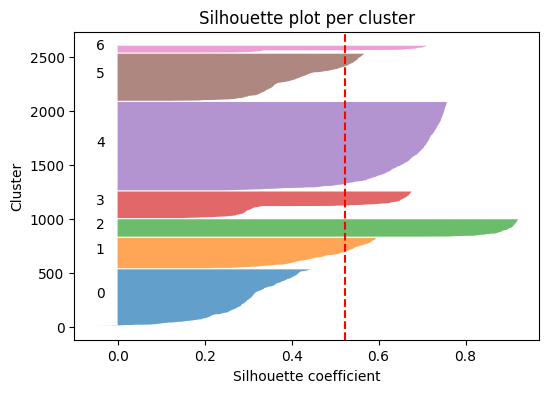

In [15]:
sil_vals = silhouette_samples(X_, cluster_labels)
y_lower = 10
plt.figure(figsize=(6,4))

for cid in np.unique(cluster_labels):
    c_sil = sil_vals[cluster_labels == cid]
    c_sil.sort()
    y_upper = y_lower + len(c_sil)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, c_sil, alpha=0.7)
    plt.text(-0.05, y_lower + len(c_sil)/2, str(cid))
    y_lower = y_upper + 10

plt.xlabel("Silhouette coefficient"); plt.ylabel("Cluster")
plt.axvline(sil_vals.mean(), color="red", linestyle="--")

plt.title("Silhouette plot per cluster")
plt.show()

## Feature Importance with Classification

In [16]:
t = DecisionTreeClassifier(max_depth=6, random_state=42)
feature_cols = [col for col in df.columns if col != "cluster_abr" and col != "cluster_name"]
t.fit(df[feature_cols], kmeans.labels_)
feat_imp = pd.Series(t.feature_importances_, index=feature_cols).sort_values(ascending=False)
feat_imp

Surface Water Rights 2018-01-01    0.333920
cluster                            0.225944
PET 1996-11-01                     0.178228
Temp Min 2005-05-01                0.123259
Precipitation 1986-10-01           0.093196
                                     ...   
Temp Max 1987-08-01                0.000000
Temp Max 1987-07-01                0.000000
Temp Max 1987-06-01                0.000000
Temp Max 1987-05-01                0.000000
Temp Max 2019-10-01                0.000000
Length: 2291, dtype: float64

Because of the way the data is formatted, interpret the above as general groups of variables/times instead of specific dates. One specific column or date might represent an overall trend. For example, surface water rights in 2018 is not as important as the overall trend.

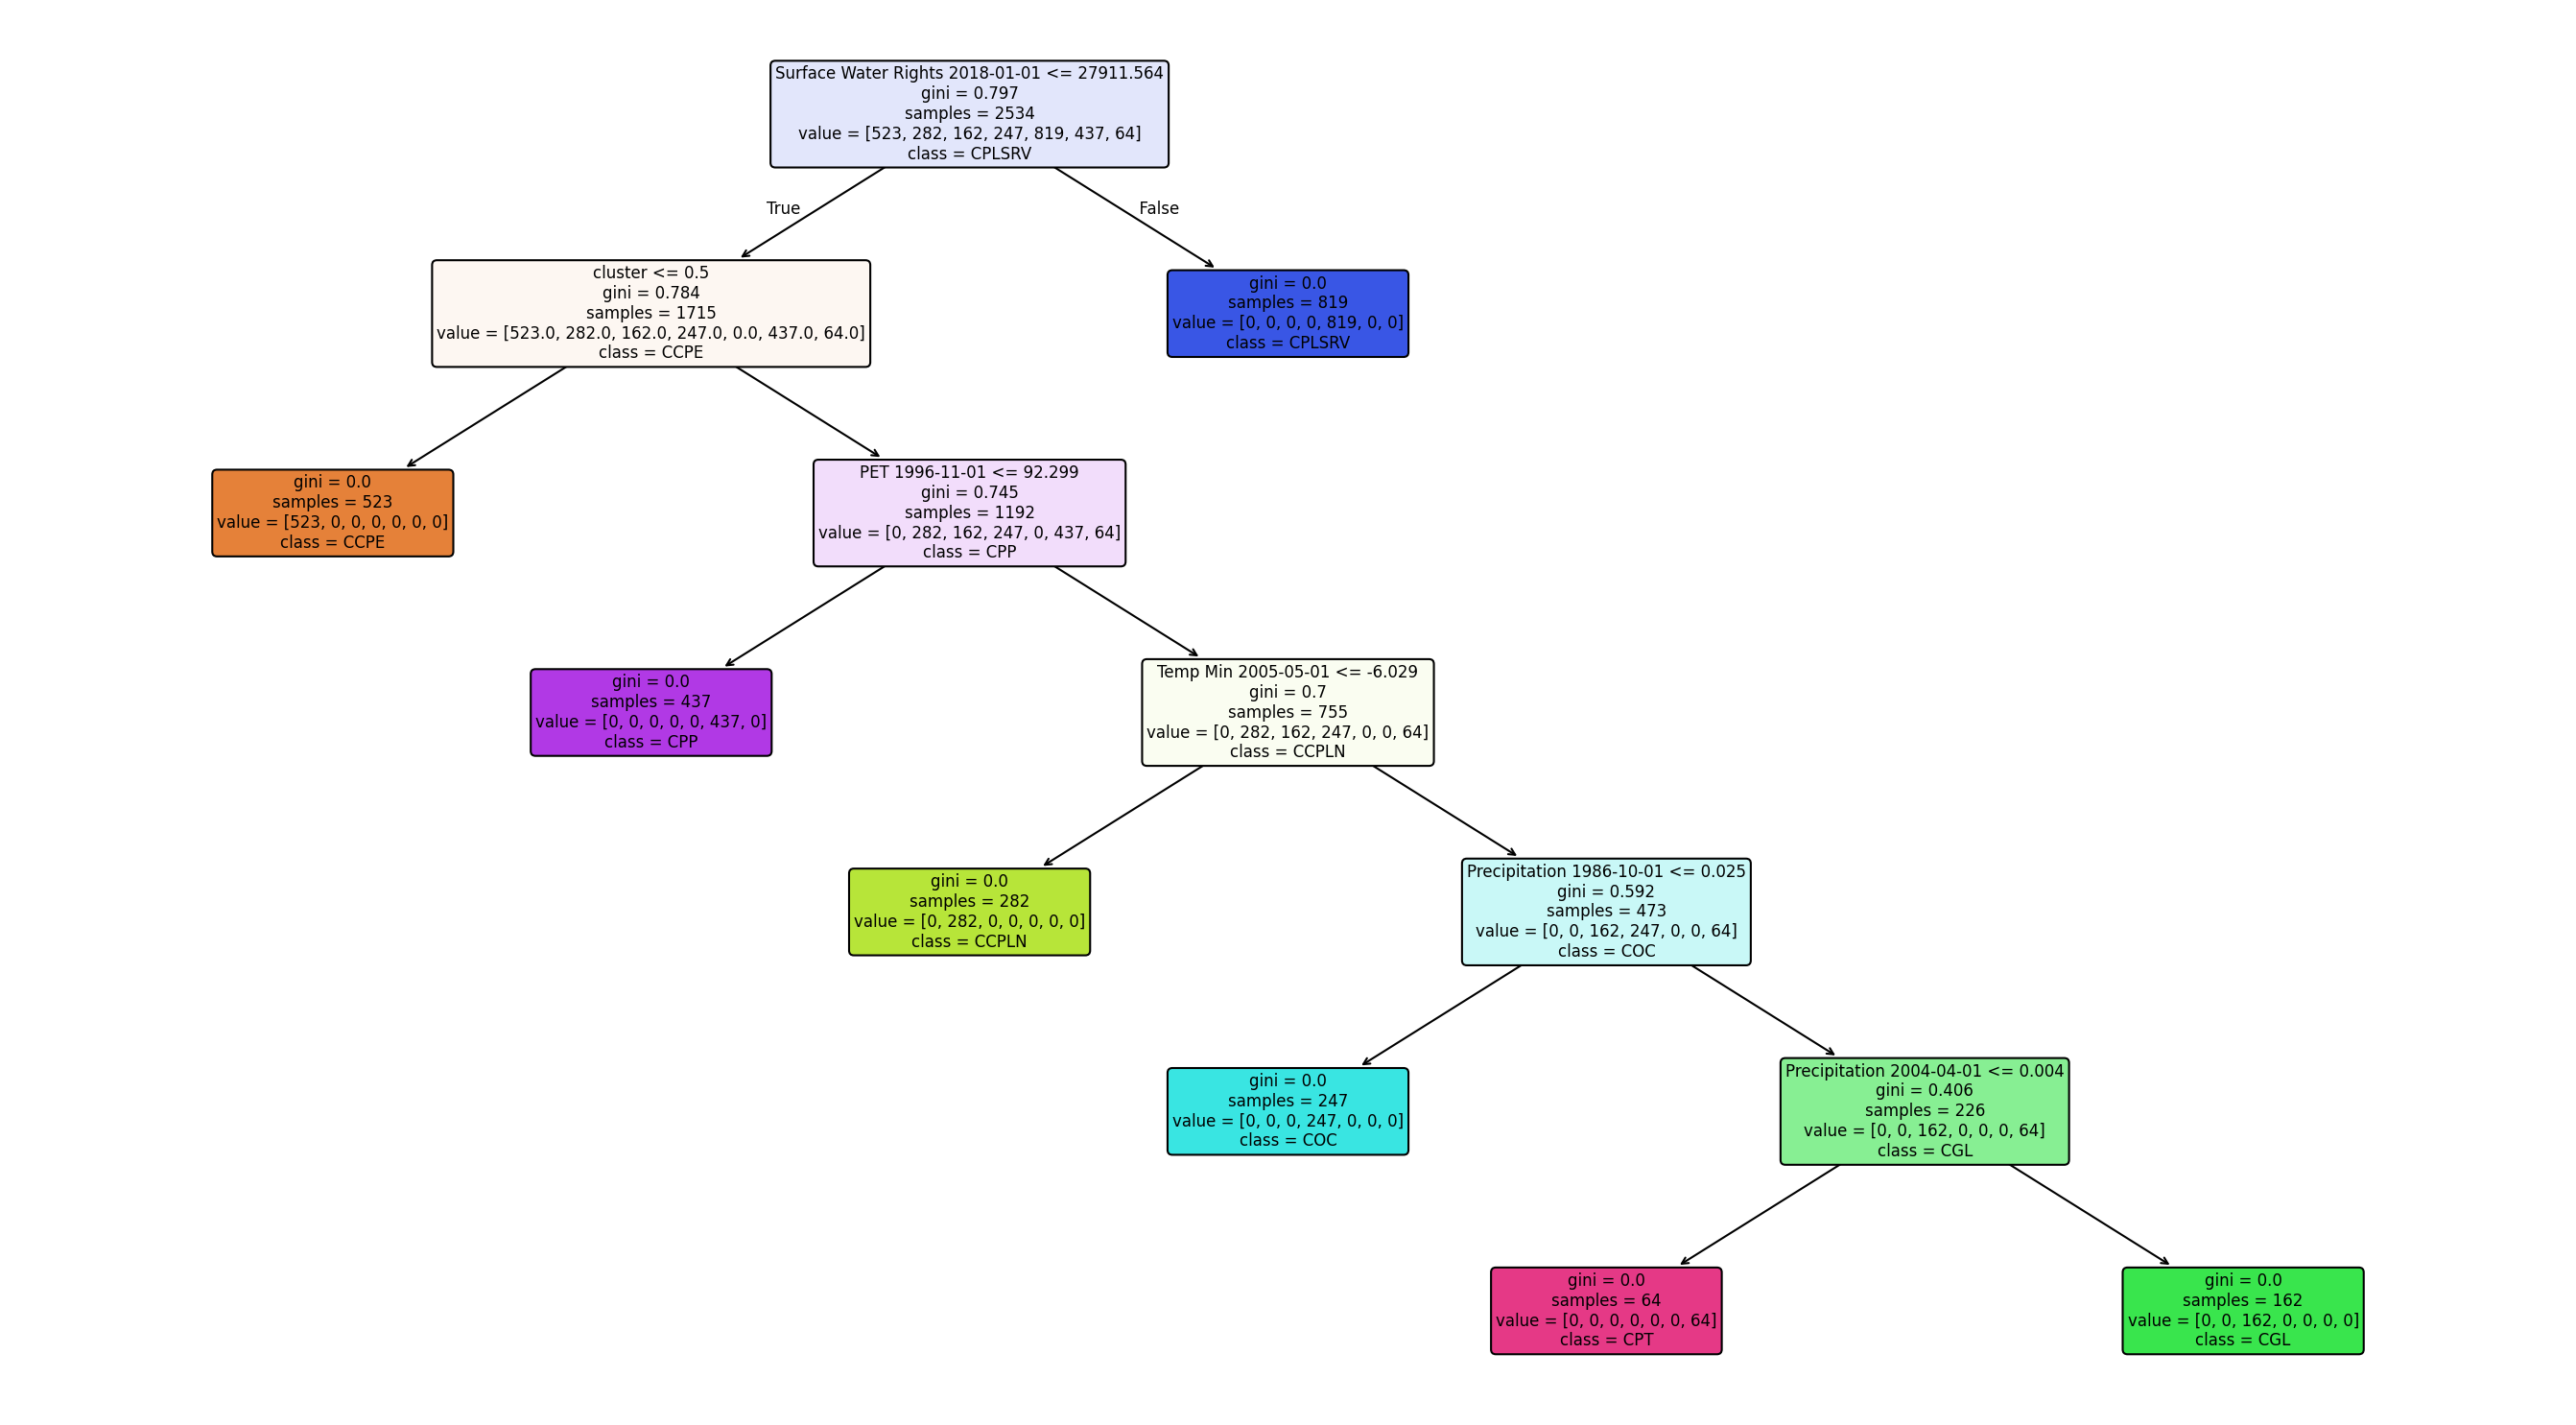

In [17]:
fig, ax = plt.subplots(figsize=(18, 10), dpi=150)
tree.plot_tree(
        t,
        feature_names=feature_cols,
        class_names=[f"C{i}" for i in sorted(set(df["cluster_abr"]))],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax)
plt.tight_layout()
# gini is a purity measurement, where gini=0 means this leaf contains all bofedales belonging to the cluster

## Data Visualizations

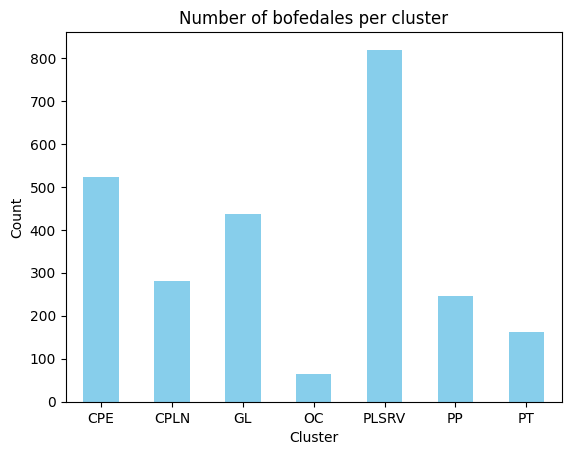

In [18]:
pd.Series(df["cluster_abr"]).value_counts().sort_index().plot.bar(color='skyblue')
plt.xlabel("Cluster"); plt.ylabel("Count")
plt.title("Number of bofedales per cluster")
plt.xticks(rotation=0)
plt.show()

In [19]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

gdf = gpd.GeoDataFrame(
    df.copy(), 
    geometry=geometry,
    crs="EPSG:4326"
)

gdf_4326 = gdf.to_crs(4326)
gdf_4326["size_for_plot"] = gdf["Area_m2"].apply(lambda a: (a**0.5))

gdf_4326["lon"] = gdf_4326.geometry.x
gdf_4326["lat"] = gdf_4326.geometry.y

tab10 = plt.colormaps.get_cmap("tab10")
cluster_ids = sorted(gdf_4326["cluster_abr"].unique())

cluster_colors = {
    cid: mcolors.to_hex(tab10(i % tab10.N))
    for i, cid in enumerate(cluster_ids)
}

center = [gdf_4326.lat.mean(), gdf_4326.lon.mean()]
m = folium.Map(center, zoom_start=6, tiles="OpenStreetMap")

sz = gdf_4326["size_for_plot"]
radii = np.interp(sz, (sz.min(), sz.max()), (2, 20))

for (_, row), radius in zip(gdf_4326.iterrows(), radii):
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=radius,
        fill=True,
        fill_opacity=0.6,
        weight=0.3,
        color="black",
        fill_color=cluster_colors[row.cluster_abr],
        popup=(
            f"Cluster {row.cluster_abr}<br>"
            f"Area = {row.Area_m2:,} m²"
        ),
    ).add_to(m)
m

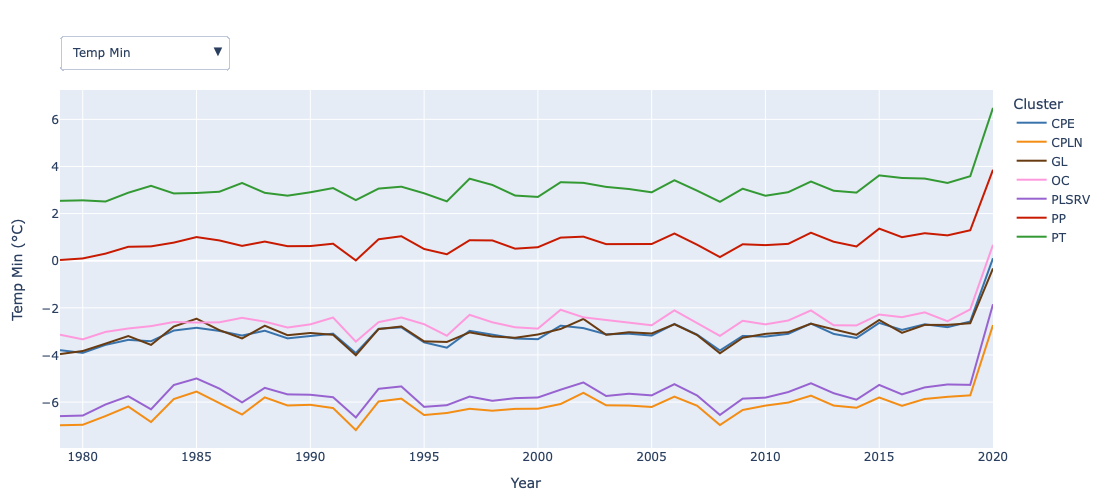

In [20]:
unit_mapping = {
    "Temp Min": "°C", 
    "Temp Max": "°C", 
    "Precipitation": "mm", 
    "Ground Water Rights": "L/s", 
    "Surface Water Rights": "L/s", 
    "PET": "mm", 
    "NDVI": "", 
    "NDWI": ""
}
vars_order = list(unit_mapping.keys())
default_var = vars_order[0]

# Optional guide-lines
guide_lines = [
    # {"value": 0.0, "orientation": "h", "label": "Zero line", "color": "grey", "style": "dash", "width": 1},
]

long_parts = []
for var in vars_order:
    var_cols = [c for c in df.columns if c.startswith(f"{var} ")]
    if not var_cols:
        continue

    block = df[var_cols + ["cluster_abr"]].copy()
    date_index = pd.to_datetime(
        [c.replace(f"{var} ", "") for c in var_cols], errors="raise"
    )
    block.columns = date_index.tolist() + ["cluster_abr"]

    block = block.melt(id_vars="cluster_abr", var_name="date", value_name="value")
    block["variable"] = var
    block["date"] = pd.to_datetime(block["date"], errors="raise")

    long_parts.append(block)

tidy = pd.concat(long_parts, ignore_index=True)

tidy["year"] = tidy["date"].dt.year
tidy_annual = (
    tidy
      .groupby(["cluster_abr", "variable", "year"], as_index=False)
      .mean(numeric_only=True)
)

clusters = tidy_annual["cluster_abr"].unique()

fig = go.Figure()

for clus in clusters:
    sub = tidy_annual.query("cluster_abr == @clus and variable == @default_var")
    fig.add_trace(
        go.Scatter(
            x=sub["year"],
            y=sub["value"],
            mode="lines",
            name=clus,
            line=dict(color=cluster_palette[clus], width=2)
        )
    )

for ln in guide_lines:
    if ln["orientation"].lower().startswith("h"):
        fig.add_shape(
            type="line",
            x0=tidy_annual["year"].min(), x1=tidy_annual["year"].max(),
            y0=ln["value"], y1=ln["value"],
            line=dict(color=ln.get("color", "red"),
                      dash=ln.get("style", "dash"),
                      width=ln.get("width", 2))
        )
    else:
        fig.add_shape(
            type="line",
            y0=tidy_annual["value"].min(), y1=tidy_annual["value"].max(),
            x0=ln["value"], x1=ln["value"],
            line=dict(color=ln.get("color", "red"),
                      dash=ln.get("style", "dash"),
                      width=ln.get("width", 2))
        )

buttons = []
for var in vars_order:
    ys = [
        tidy_annual.query("cluster_abr == @clus and variable == @var")["value"].values
        for clus in clusters
    ]
    label = var + (f" ({unit_mapping[var]})" if unit_mapping[var] else "")
    buttons.append(
        dict(
            label  = var,
            method = "update",
            args   = [
                {"y": ys},
                {
                  "title": f"Average {var} by Cluster",
                  "yaxis": {"title": {"text": label}}
                }
            ]
        )
    )

fig.update_layout(
    xaxis_title="Year",
    yaxis_title=f"{default_var}" + (f" ({unit_mapping[default_var]})" if unit_mapping[default_var] else ""),
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        showactive=True,
        buttons=buttons,
        x=0.0, xanchor="left",
        y=1.15, yanchor="top"
    )],
    legend_title_text="Cluster",
    height=500, width=900,
    margin=dict(t=90, r=20, l=60, b=50)
)

fig

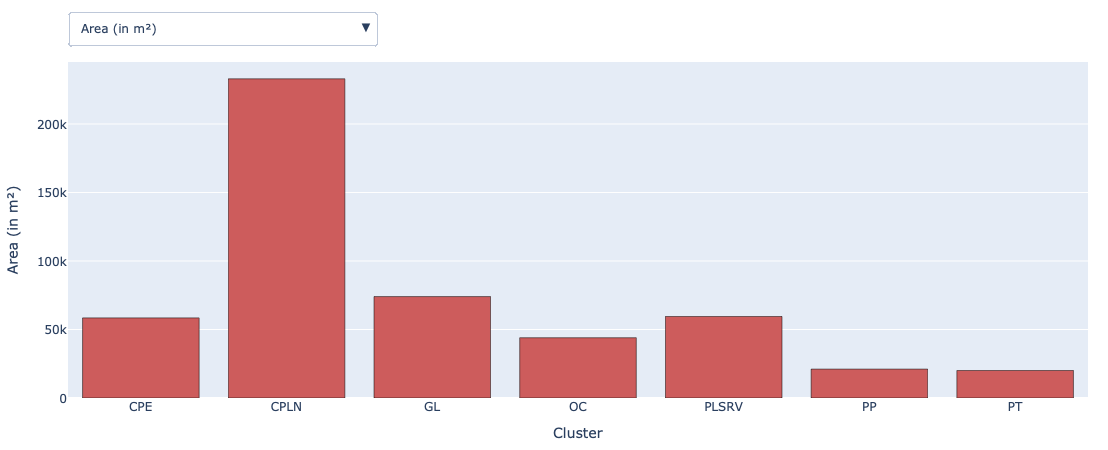

In [21]:
palette = [
    "indianred","lightsalmon","mediumaquamarine","powderblue","darkslateblue",
    "mediumturquoise","lavender","palevioletred","olivedrab","lightpink",
    "gold","mediumvioletred","lightcoral","tomato","sandybrown",
]

df_condensed = (
    df[['Area_m2', 'AUC', 'pct_prot', 'elev_mean_', 'elev_std_m',
        'n_wells', 'cluster', 'cluster_abr']]
      .rename(columns={
          'pct_prot': 'Percentage Protected Land (of total bofedal)',
          'Area_m2' : 'Area (in m²)',
          'AUC'     : 'Area of basin',
          'elev_mean_': 'Average Elevation (in m)',
          'elev_std_m': 'Elevation Standard Deviation (in m)',
          'n_wells'   : 'Number of wells (per catchment area)',
      })
)

agg = (df_condensed
       .groupby("cluster_abr", as_index=False)
       .mean())

def make_trace(var, colour):
    return go.Bar(
        x=agg["cluster_abr"],
        y=agg[var],
        marker=dict(color=colour, line=dict(color="black")),
        name=var
    )

vars_list   = list(agg.columns[1:])
default_var = vars_list[0]

fig = go.Figure(make_trace(default_var, palette[0]))

buttons = []
for i, var in enumerate(vars_list):
    buttons.append(
        dict(
            label  = var,
            method = "update",
            args   = [
                {"y": [agg[var]],
                 "marker.color": [palette[i % len(palette)]]},
                {
                  "yaxis": {"title": {"text": var}}
                }
            ]
        )
    )

fig.update_layout(
    title="",
    yaxis=dict(title=dict(text=default_var)),
    xaxis=dict(
        title="Cluster",
        type="category",
        categoryorder="array",
        categoryarray=agg["cluster_abr"].tolist()
    ),
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        showactive=True,
        buttons=buttons,
        x=0.0, xanchor="left",
        y=1.15, yanchor="top"
    )],
    margin=dict(t=60, r=20, l=60, b=50),
    height=450, width=700,
    showlegend=False
)


fig